In [1]:
% matplotlib inline

import time
import pandas as pd

from IPython import display as d

import numpy as np

import seaborn as sns
sns.set()

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from libs import container
from libs.experiment import (
    WithAnotherExperiment, KFoldExperiment, roc, 
    discretize_classes, clean_features)

import pytff


from libs import fourier_help

from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

In [2]:
start = time.time()

path = "/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/"
data = container.read(path)

Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b261.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b263.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b264.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b262.npy'...
Loading '/home/data/carpyncho/stored/samples/smp_2500_rrVSunk/b278.npy'...


In [3]:
_, classes, sclasses = discretize_classes(data)

In [4]:
ogle3 = pd.read_table("/home/jbcabral/projects/paper_b278/src/legacy/data/ogle_rr.txt", header=6)
ogle3.columns

/home/jbcabral/projects/paper_b278/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'# ID', u'Field', u'StarID', u'RA', u'Decl', u'Type', u'I', u'V',
       u'P_1', u'dP_1', u'T0_1', u'A_1', u'R21_1', u'phi21_1', u'R31_1',
       u'phi31_1', u'P_2', u'dP_2', u'T0_2', u'A_2', u'R21_2', u'phi21_2',
       u'R31_2', u'phi31_2', u'ID_OGLE_II', u'ID_MACHO', u'ID_GCVS',
       u'ID_OTHER', u'Remarks'],
      dtype='object')

In [5]:
tile = pd.DataFrame(np.load("/home/data/carpyncho/stored/npy_tiles/cat_b278_jhk_1.npy"))

In [6]:
df = data.b278

In [7]:
def get_o3id(o3id):
    return ogle3[ogle3["# ID"] == o3id].P_1.values[0]
    
rr = df[df.scls == 3].copy()
rr["ogle3_id"] = rr.id.apply(lambda cid: tile[tile.id == cid].ogle3_id.values[0])
rr["ogle3_period"] = rr.ogle3_id.apply(get_o3id)
rr["fvo3_p"] = np.abs(rr.PeriodLS - rr.ogle3_period)

('Observation', '114', 6)


,id,ra_h,dec_h,ra_j,dec_j,ra_k,dec_k,mag_h,mag_j,mag_k,...,c89_ah_vvv,c89_jk_color,c89_hk_color,c89_jh_color,n09_ak_vvv,n09_aj_vvv,n09_ah_vvv,n09_jk_color,n09_hk_color,n09_jh_color
99370,32780000099371,271.103108,-30.855253,271.103108,-30.855289,271.103158,-30.855264,14.516,14.912,14.325,...,0.372822,0.264901,0.060648,0.204253,0.18647,0.506967,0.304136,0.266503,0.073334,0.193169


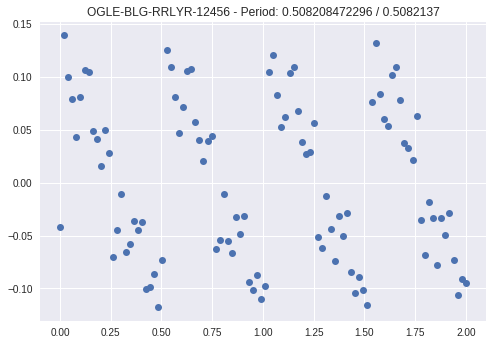

In [8]:
sample = rr.sample().iloc[0]
data = fourier_help.fourier_data(sample, "FATS")
period = sample.PeriodLS
ogle3_id = tile[tile.id == sample.id].ogle3_id.values[0]
x, y = pytff.fspace(data, 0., 2, 100)
plt.title("{} - Period: {} / {}".format(ogle3_id, period, sample.ogle3_period))
plt.plot(x, y, "o");

print("Observation", sample.cnt, sample.cls)
d.display(tile[tile.id == sample.id])

In [9]:
sample.ogle3_id

'OGLE-BLG-RRLYR-12456'

In [10]:
# 32780000534721
url = "http://ogledb.astrouw.edu.pl/~ogle/CVS/getobj.php?starcat={}&sqlsrv=localhost&database=cvs&sqldb=all_catalog&target=all&qtype=catalog".format(sample.ogle3_id)
# print url
d.IFrame(url, "100%", 400)

In [11]:
classes

{'': 0,
 'Cep-1': 1,
 'Cep-F': 2,
 'LPV-Mira': 3,
 'LPV-OSARG': 4,
 'LPV-SRV': 5,
 'RRLyr-RRab': 6,
 'RRLyr-RRc': 7,
 'RRLyr-RRd': 8,
 'T2Cep-BLHer': 9,
 'T2Cep-RVTau': 10,
 'T2Cep-WVir': 11}

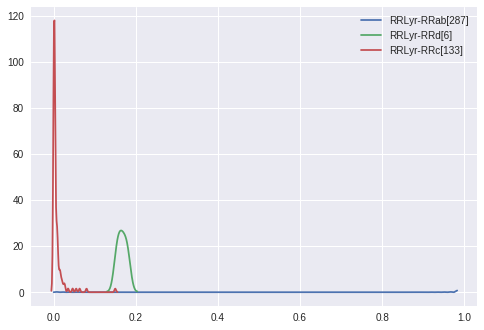

In [12]:
for name, num in classes.items():
    if not num: 
        continue
    stars = rr[rr.cls==num]
    if not len(stars):
        continue
    sns.kdeplot(stars.fvo3_p / stars.fvo3_p.sum(), label="{}[{}]".format(name, len(stars)))

# ax = sns.kdeplot(rr.ogle3_period / rr.ogle3_period.sum())

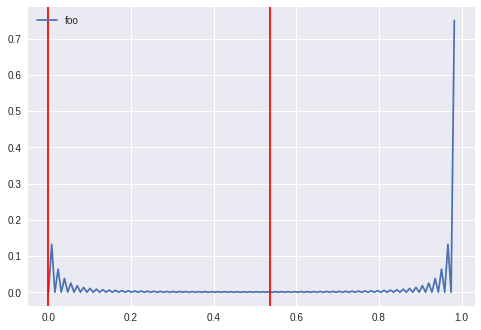

In [28]:
ax = sns.kdeplot(rr[rr.cls==6].fvo3_p / rr[rr.cls==6].fvo3_p.sum(), label="foo")
ax.axvline(rr[rr.cls==6].fvo3_p.quantile(), color="r", linestyle="-")
ax.axvline(rr[rr.cls==6].fvo3_p.quantile(0.90), color="r", linestyle="-")

In [29]:
rr[rr.cls==6].fvo3_p.describe()

count    2.870000e+02
mean     6.968714e+01
std      1.159761e+03
min      6.018033e-09
25%      7.286990e-06
50%      1.736073e-05
75%      5.717046e-05
max      1.964737e+04
Name: fvo3_p, dtype: float64